# Nearest Neighbors Classification


Sample usage 2 of Nearest Neighbors classification.
It will plot the decision boundaries for each class.

Code from [benalexkeen.com](http://benalexkeen.com/k-nearest-neighbours-classification-in-python/)


In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn import neighbors
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score


In [2]:
# import data 
wq_df = pd.read_csv('Data/SFBayWaterQualityCleaned.csv', 
                    header=0, 
                    parse_dates=['DateTime', 'Date'],
                    dtype={'Station' : str}
                    )

# Station Groups
# 0: South Bay 
# 1: Central Bay
# 2: Golden Gate
# 3: San Pablo Bay
# 4: Suisun Bay
# 5: Sacramento River

st_group = {0: ['36', '35', '34', '33', '32', '31', '30', '29.5'], 
            1: ['29', '28.5', '28', '27', '26', '25', '24', '23'], 
            2: ['22', '21', '20', '19', '18', '17', '16', '15'], 
            3: ['14', '13', '12.5', '12', '11', '10', '9', '8'], 
            4: ['405', '7', '6', '5', '411', '407', '4', '3'], 
            5: ['2', '649', '650', '651', '652', '653', '654', 
                '655', '657', '659', '662']}

def label_group (row):
    #print("station", row['Station'])
    for gid in st_group:
        #print("gid", gid)
        if (row['Station'] in st_group[gid]):
            #print(row['Station'], "matches group", gid)
            return(gid)
            
wq_df['Station_group'] = wq_df.apply(lambda row: label_group(row), axis=1)

wq_df_sub = wq_df[(wq_df.Date >= '2019-06-04') & 
                       (wq_df.Date < '2019-06-05') &
                       (wq_df['Salinity'].notnull()) &
                       (wq_df['Temperature'].notnull()) &
                       (wq_df['Calculated Chlorophyll'].notnull())
                     ]

working_df = wq_df_sub[['Salinity', 'Temperature', 
                        'Calculated Chlorophyll', 'Station_group']].copy()
working_df.Station_group = working_df.Station_group.astype('str')


In [3]:
# create design matrix X and target vector y
y = working_df['Station_group'].values
X = working_df.drop('Station_group', axis=1).values


In [4]:
scaler = preprocessing.MinMaxScaler()
X = scaler.fit_transform(X)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [6]:
from sklearn.decomposition import PCA

pca_model = PCA(n_components=2)
pca_model.fit(X_train)
X_train = pca_model.transform(X_train)
X_test = pca_model.transform(X_test)

# 2-Dimensions
X_train[:5]


array([[-0.06579745, -0.18485226],
       [-0.49343477, -0.01874382],
       [-0.51965877,  0.03854279],
       [-0.47481328, -0.24379343],
       [-0.50550093, -0.12795334]])

In [7]:
# instantiate learning model 
k = 5
knn_model = neighbors.KNeighborsClassifier(n_neighbors=k)

# fit the model
knn_model.fit(X_train, y_train) 

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [9]:
# predict the response
y_predict = knn_model.predict(X_test)

# evaluate accuracy
print("accuracy: {}".format(accuracy_score(y_test, y_predict)))

accuracy: 0.9663865546218487


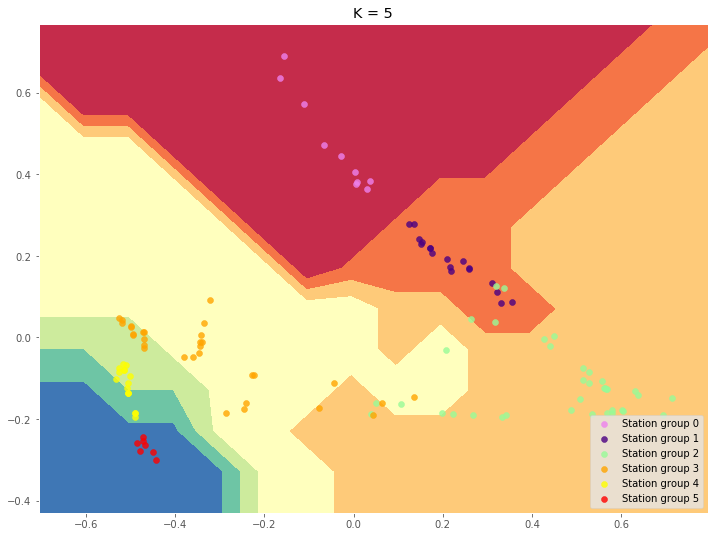

In [10]:
# Plot the results
colors = {0: 'violet', 1: 'indigo', 2: 'palegreen', 
          3: 'orange', 4: 'yellow', 5: 'red'
         }

plt.style.use('ggplot') 

fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111)
padding = 0.1
resolution = 0.1

x_min, x_max = X_train[:, 0].min(), X_train[:, 0].max()
y_min, y_max = X_train[:, 1].min(), X_train[:, 1].max()
x_range = x_max - x_min
y_range = y_max - y_min
x_min -= x_range * padding
y_min -= y_range * padding
x_max += x_range * padding
y_max += y_range * padding

# Get decision boundaries from model
xx, yy = np.meshgrid(np.arange(x_min, x_max, resolution),
                     np.arange(y_min, y_max, resolution))

Z = knn_model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot the contour map
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
plt.axis('tight')

# Plot your testing points as well
for label in np.unique(y_test):
    l = int(label)
    indices = np.where(y_test == label)
    plt.scatter(X_test[indices, 0], X_test[indices, 1], c=colors[l], alpha=0.8, 
               label='Station group {}'.format(label))

plt.legend(loc='lower right')
plt.title('K = {}'.format(k))
plt.show()

The plot implies that I might get better results if I adjust station groups 2, 3, and 4 slightly.